In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any

import numpy as np
from torch.utils.data import DataLoader,TensorDataset
import time
import matplotlib.pyplot as plt

In [2]:
class EncoderRNN(nn.Module):
    """Encoder Network."""
    def __init__(self,
                 input_size: int = 2,
                 embedding_size: int = 8,
                 hidden_size: int = 16):
        """Initialize the encoder network.
        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)

    def forward(self, x: torch.FloatTensor, hidden: Any) -> Any:
        """Run forward propagation.
        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            hidden: final hidden 
        """
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        return hidden


In [3]:
class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=8, hidden_size=16, output_size=2):
        """Initialize the decoder network.
        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output
        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(output_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        """Run forward propagation.
        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state
        """
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden

In [4]:
#train_set = train_set.transpose(0,2,1)
#train_target = train_target.transpose(0,2,1)
#train_set.shape,train_target.shape

train_data = np.load("train_velocity.npy")
train_data.shape

(208272, 2, 49)

In [5]:
toTensor_sig = torch.tensor(train_data[0:208272:10])
train_data_set = TensorDataset(toTensor_sig)

In [6]:
#set up the train parameters
batch_size = 1000 #600 #500
epoch = 70
lr = 0.001

encoder = EncoderRNN()
decoder = DecoderRNN()
criterion = nn.MSELoss()
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
tr_data_loader = DataLoader(train_data_set,batch_size = batch_size, shuffle = True)
loss_overall = []

In [ ]:

start = time.time()

for i in range(epoch):
    print("============================================")
    print("epoch: ", i+1)
    loss_batch = 0
    cur_MSE = 0
    for (idx,data) in enumerate(tr_data_loader):
        feature = data[0][:,:,0:29]#.permute(0,2,1)
        #print(feature.shape)
        target = data[0][:,:,29:49]
        #print(target)
        encoder_hidden =(
            torch.zeros(feature.shape[0], 16),
            torch.zeros(feature.shape[0], 16),
        )
        
        loss = 0
        
        
        for cur_fea in range(feature.shape[2]):
            encoder_input = feature[:,:,cur_fea]
            #print((encoder_input.shape))
            #print(encoder_hidden[0].dtype)
            encoder_hidden = encoder(encoder_input.type(torch.FloatTensor), encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]
        #print(decoder_input.shape)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(target.shape)
        
        for di in range(20):
            decoder_output, decoder_hidden = decoder(decoder_input.type(torch.FloatTensor),
                                                     decoder_hidden)
            decoder_outputs[:, :, di] = decoder_output

            # Update losses for all benchmarks
            loss += criterion(decoder_output[:, :], target[:, :, di].type(torch.FloatTensor))
            

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
            
        
        #loss = criterion(decoder_outputs, target.type(torch.FloatTensor))
        # Get average loss for pred_len
        #loss = (loss/batch_size).type(torch.FloatTensor)
        #cur_MSE += loss
        #print(loss.dtype)
        loss = loss/20
        loss_batch+= loss
        #print(loss)
        loss.backward()
        encoder_optimizer.step()
        #print("decoder")
        decoder_optimizer.step()
        #print(decoder_outputs)
        #print(target)
        #break
    #loss_overall.append(cur_MSE)
    print(loss_batch/batch_size)    #average loss per batch
    loss_overall.append(loss_batch/batch_size)





epoch:  1
tensor(0.5550, grad_fn=<DivBackward0>)
epoch:  2
tensor(0.3392, grad_fn=<DivBackward0>)
epoch:  3
tensor(0.2556, grad_fn=<DivBackward0>)
epoch:  4
tensor(0.2639, grad_fn=<DivBackward0>)
epoch:  5
tensor(0.2628, grad_fn=<DivBackward0>)
epoch:  6
tensor(0.2504, grad_fn=<DivBackward0>)
epoch:  7
tensor(0.2558, grad_fn=<DivBackward0>)
epoch:  8
tensor(0.3607, grad_fn=<DivBackward0>)
epoch:  9
tensor(0.6093, grad_fn=<DivBackward0>)
epoch:  10
tensor(0.5712, grad_fn=<DivBackward0>)
epoch:  11
tensor(0.6293, grad_fn=<DivBackward0>)
epoch:  12
tensor(1.9020, grad_fn=<DivBackward0>)
epoch:  13
tensor(2.9094, grad_fn=<DivBackward0>)
epoch:  14
tensor(4.1628, grad_fn=<DivBackward0>)
epoch:  15
tensor(5.8051, grad_fn=<DivBackward0>)
epoch:  16
tensor(7.5692, grad_fn=<DivBackward0>)
epoch:  17
tensor(8.5917, grad_fn=<DivBackward0>)
epoch:  18
tensor(9.4504, grad_fn=<DivBackward0>)
epoch:  19
tensor(9.1826, grad_fn=<DivBackward0>)
epoch:  20
tensor(9.2202, grad_fn=<DivBackward0>)
epoch:  2

In [8]:
torch.save(encoder,'trained_encoder_1129.pth')
torch.save(decoder,'trained_decoder_1129.pth')

## Print learning curve

In [9]:

for i in range(len(loss_overall)):
    loss_overall[i] = loss_overall[i].detach().numpy()


[array(4.4679494, dtype=float32), array(2.1656873, dtype=float32), array(1.3509207, dtype=float32), array(1.104406, dtype=float32), array(1.0879691, dtype=float32)]


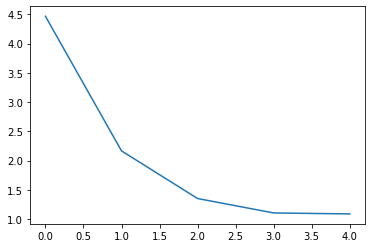

In [10]:
print(loss_overall)
plt.plot(loss_overall)
    

In [47]:

print("training time: ", end - start)

NameError: name 'end' is not defined

# Test

## test dataset

In [130]:
toTensor_sig = torch.tensor(train_data[1:208272:10])
test_data_set = TensorDataset(toTensor_sig)

In [131]:
encoder = torch.load("trained_encoder_10_downsample.pth")
decoder = torch.load("trained_decoder_10_downsample.pth")

In [132]:
te_data_loader = DataLoader(test_data_set,batch_size = batch_size, shuffle = False)

In [133]:
predict = []
ground_truth = []
error = 0

In [134]:
for (idx,data) in enumerate(te_data_loader):
        feature = data[0][:,:,0:29]#.permute(0,2,1)
        #print(feature.shape)
        target = data[0][:,:,29:49]
        ground_truth.append(target)
        encoder_hidden =(
            torch.zeros(feature.shape[0], 16),
            torch.zeros(feature.shape[0], 16),
        )
        
        loss = 0
        
        
        for cur_fea in range(feature.shape[2]):
            encoder_input = feature[:,:,cur_fea]
            #print((encoder_input.shape))
            #print(encoder_hidden[0].dtype)
            encoder_hidden = encoder(encoder_input.type(torch.FloatTensor), encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = encoder_input[:, :2]

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden
        decoder_outputs = torch.zeros(target.shape)
        
        for di in range(20):
            decoder_output, decoder_hidden = decoder(decoder_input.type(torch.FloatTensor),decoder_hidden)
            decoder_outputs[:, :, di] = decoder_output

            # Update losses for all benchmarks
            loss += criterion(decoder_output[:, :], target[:, :, di].type(torch.FloatTensor))

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
        error += loss
        loss = loss / 20
        predict.append(decoder_outputs)
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


# observe the velocity

In [135]:
predict[0][3]

tensor([[ 1.3971,  1.0320,  1.0837,  1.0908,  1.0918,  1.0919,  1.0920,  1.0920,
          1.0920,  1.0920,  1.0920,  1.0920,  1.0920,  1.0920,  1.0920,  1.0920,
          1.0920,  1.0920,  1.0920,  1.0920],
        [ 9.2632, 10.0748, 10.2747, 10.3023, 10.3060, 10.3065, 10.3066, 10.3066,
         10.3066, 10.3066, 10.3066, 10.3066, 10.3066, 10.3066, 10.3066, 10.3066,
         10.3066, 10.3066, 10.3066, 10.3066]], grad_fn=<SelectBackward0>)

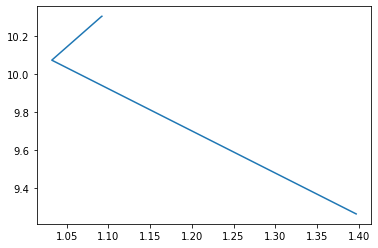

In [136]:
plt.plot(predict[0][3][0].detach().numpy(),predict[0][3][1].detach().numpy())

In [137]:
ground_truth[0][3]

tensor([[-0.4152, -0.4039, -0.4054, -0.4543, -0.3499, -0.4574, -0.3950, -0.3786,
         -0.4150, -0.4008, -0.4038, -0.3959, -0.3986, -0.4482, -0.4057, -0.4401,
         -0.3993, -0.4099, -0.4165, -0.4083],
        [10.4431, 10.4902, 10.5210, 12.6421,  8.3810, 12.6110, 10.5605, 10.5814,
         10.5987, 10.5776, 10.5935, 10.6567, 10.6054, 11.6653, 10.6246, 11.7575,
         10.6129, 10.6362, 10.7001, 10.6295]], dtype=torch.float64)

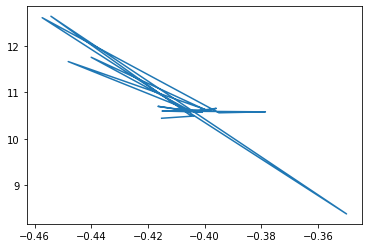

In [138]:
plt.plot(ground_truth[0][3][0].detach().numpy(),ground_truth[0][3][1].detach().numpy())

In [139]:
train_data[31]

array([[-0.43092714, -0.40919948, -0.46579345, -0.34830359, -0.4873915 ,
        -0.38331933, -0.44114487, -0.35705632, -0.44052414, -0.42714435,
        -0.4261904 , -0.33040971, -0.42589769, -0.37554081, -0.38198167,
        -0.41551529, -0.33244577, -0.40627243, -0.36463625, -0.40802562,
        -0.3678185 , -0.39253873, -0.40368555, -0.37223163, -0.43669586,
        -0.33824074, -0.38052763, -0.44694556, -0.39436007, -0.41519471,
        -0.40391339, -0.40541985, -0.45427652, -0.34992613, -0.45736888,
        -0.39496744, -0.37856035, -0.41504027, -0.40081377, -0.40378541,
        -0.3959084 , -0.39855564, -0.44817388, -0.40574693, -0.44006053,
        -0.39932936, -0.40993389, -0.41649071, -0.40831913],
       [11.33739127, 10.6076954 , 11.67378359,  8.52341242, 12.78745879,
        10.65806861, 10.64555718,  9.54770107, 11.7072013 , 11.74705716,
        10.62764784,  9.57861725, 12.68325366, 10.47061212,  9.40834036,
        11.48915245,  9.40711642, 11.45819409, 10.35097262, 11.

In [140]:
predict[0][0]

tensor([[ 0.0198,  0.1225,  0.1378,  0.1399,  0.1402,  0.1402,  0.1402,  0.1402,
          0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,
          0.1402,  0.1402,  0.1402,  0.1402],
        [-0.6814, -0.9319, -0.9705, -0.9759, -0.9766, -0.9767, -0.9767, -0.9767,
         -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767,
         -0.9767, -0.9767, -0.9767, -0.9767]], grad_fn=<SelectBackward0>)

In [141]:
ground_truth[0][0]

tensor([[ 8.4051e-02,  2.0257e-01,  1.2560e-01, -5.6649e-02, -2.4978e-02,
          9.7937e-02,  2.7491e-01,  7.8219e-01,  9.9808e-01,  1.6083e+00,
          1.9529e+00,  2.4643e+00,  3.1303e+00,  3.3997e+00,  3.9952e+00,
          4.3497e+00,  5.1009e+00,  5.5272e+00,  5.5230e+00,  6.2178e+00],
        [ 1.4382e-02,  1.8956e-02,  1.1027e-02,  5.9880e-03,  6.5454e-03,
          1.5455e-02,  1.2154e-02,  4.2269e-02,  4.9611e-02,  6.7911e-02,
          8.5632e-02,  9.4671e-02,  1.1151e-01,  1.1930e-01,  1.1120e-01,
          1.3838e-01,  1.4776e-01,  1.2418e-01,  1.5055e-01,  1.4308e-01]],
       dtype=torch.float64)

In [142]:
train_data[1]

array([[ 1.18207279e+00,  1.23291415e+00,  1.17795915e+00,
         1.30921899e+00,  1.16738404e+00,  1.10513157e+00,
         1.25042092e+00,  1.23006751e+00,  1.01515814e+00,
         8.49094128e-01,  4.81532938e-01,  1.81027265e-01,
        -7.45337933e-02,  1.65495171e-02, -1.14981817e-02,
         7.76208708e-02,  1.64696130e-01,  2.37584831e-01,
         1.39908452e-01,  1.02707774e-02, -2.24943525e-02,
        -1.20445013e-02,  2.45083239e-01,  1.75778503e-01,
         5.85503364e-01,  5.68666417e-01,  4.20695486e-01,
         6.71579465e-02,  1.26626590e-01,  8.40510857e-02,
         2.02567509e-01,  1.25599229e-01, -5.66490938e-02,
        -2.49779972e-02,  9.79366408e-02,  2.74910000e-01,
         7.82193430e-01,  9.98078697e-01,  1.60825826e+00,
         1.95292586e+00,  2.46429915e+00,  3.13034684e+00,
         3.39967519e+00,  3.99515984e+00,  4.34965118e+00,
         5.10092885e+00,  5.52723596e+00,  5.52303557e+00,
         6.21778254e+00],
       [ 4.29234075e-02,  4.30

In [143]:
predict[0][1]

tensor([[-0.3115, -2.2244, -2.7241, -0.6268,  0.0746,  0.1314,  0.1390,  0.1400,
          0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,
          0.1402,  0.1402,  0.1402,  0.1402],
        [ 3.3539,  2.4825,  1.1004, -0.8220, -0.8454, -0.9575, -0.9741, -0.9764,
         -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767,
         -0.9767, -0.9767, -0.9767, -0.9767]], grad_fn=<SelectBackward0>)

In [144]:
ground_truth[0][1]

tensor([[-0.2379, -0.3433, -0.4073, -0.5484, -0.5536, -0.6838, -0.6503, -0.6841,
         -0.8385, -0.8958, -0.8551, -0.8326, -0.9464, -0.9172, -1.0098, -1.0756,
         -0.9437, -1.0905, -1.1195, -1.2676],
        [ 4.1898,  3.8349,  3.4911,  4.1029,  3.7444,  4.0212,  3.3661,  3.2537,
          3.5040,  3.6749,  3.2714,  2.9488,  3.1032,  2.8970,  2.9478,  3.1314,
          2.6402,  2.8422,  2.8445,  3.0327]], dtype=torch.float64)

In [145]:
predict[0][2]

tensor([[ 0.0199,  0.1225,  0.1378,  0.1399,  0.1402,  0.1402,  0.1402,  0.1402,
          0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,  0.1402,
          0.1402,  0.1402,  0.1402,  0.1402],
        [-0.6813, -0.9318, -0.9705, -0.9759, -0.9766, -0.9767, -0.9767, -0.9767,
         -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767, -0.9767,
         -0.9767, -0.9767, -0.9767, -0.9767]], grad_fn=<SelectBackward0>)

In [146]:
ground_truth[0][2]

tensor([[ 0.0003,  0.0023,  0.0002,  0.0019,  0.0030,  0.0003, -0.0015,  0.0039,
          0.0037,  0.0021,  0.0053,  0.0087,  0.0062,  0.0016,  0.0116,  0.0120,
          0.0086,  0.0051,  0.0029,  0.0002],
        [-0.0010, -0.0010, -0.0009, -0.0008, -0.0010, -0.0004, -0.0015,  0.0010,
         -0.0018,  0.0018, -0.0006,  0.0039,  0.0003,  0.0004, -0.0003,  0.0026,
         -0.0014,  0.0026, -0.0009, -0.0001]], dtype=torch.float64)

In [147]:
train_data[20]

array([[-0.41657421, -0.48759838, -0.43173689, -0.42366938, -0.41262398,
        -0.45404134, -0.4134282 , -0.41038345, -0.3955261 , -0.43647969,
        -0.38916883, -0.40672038, -0.39928049, -0.42765906, -0.39175846,
        -0.38075405, -0.41619621, -0.39117519, -0.36637968, -0.38080115,
        -0.35071744, -0.42421778, -0.37304376, -0.33889211, -0.37183087,
        -0.36068559, -0.32204872, -0.30787944, -0.30817231, -0.31733483,
        -0.31133603, -0.35491394, -0.31730788, -0.33738642, -0.26795437,
        -0.29293786, -0.29342042, -0.31703405, -0.29643417, -0.34604471,
        -0.26044754, -0.28330388, -0.29368253, -0.29151988, -0.29317796,
        -0.29672931, -0.33390541, -0.30287283, -0.34689516],
       [11.31789165, 11.66628243, 10.60298908, 10.64382847, 10.60710311,
        11.65234993, 10.6337724 , 10.62407457, 10.6092171 , 11.68737544,
        10.61496524, 10.63054353, 10.62572303, 11.68735901, 10.57899855,
        10.6090932 , 11.67891999, 10.58468463, 10.62202706, 10.

In [148]:
predict[0][10]

tensor([[6.2489, 6.2777, 6.2296, 6.2209, 6.2196, 6.2195, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194],
        [3.5430, 5.3784, 5.8100, 5.8748, 5.8838, 5.8850, 5.8851, 5.8851, 5.8852,
         5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852,
         5.8852, 5.8852]], grad_fn=<SelectBackward0>)

In [149]:
ground_truth[0][10]

tensor([[7.8143, 8.6537, 7.8418, 7.8399, 7.8142, 7.8543, 7.8184, 8.6111, 7.8012,
         7.7983, 8.5899, 7.7971, 6.2667, 8.5977, 7.7713, 9.3311, 8.4329, 7.5399,
         7.4185, 7.9869],
        [7.2666, 8.0369, 7.2781, 7.2856, 7.2687, 7.3185, 7.2673, 8.0193, 7.2949,
         7.2867, 8.0141, 7.2733, 5.8367, 8.0320, 7.2624, 8.7405, 7.9131, 7.0994,
         6.9877, 7.5252]], dtype=torch.float64)

In [150]:
predict[0][15]

tensor([[1.0897, 0.1069, 0.1926, 0.3432, 0.4943, 0.5356, 0.5420, 0.5429, 0.5430,
         0.5430, 0.5430, 0.5430, 0.5430, 0.5430, 0.5430, 0.5430, 0.5430, 0.5430,
         0.5430, 0.5430],
        [4.9751, 5.0603, 5.5001, 6.6609, 7.8536, 8.1787, 8.2288, 8.2357, 8.2367,
         8.2368, 8.2368, 8.2368, 8.2368, 8.2368, 8.2368, 8.2368, 8.2368, 8.2368,
         8.2368, 8.2368]], grad_fn=<SelectBackward0>)

In [151]:
ground_truth[0][15]

tensor([[-0.2090, -0.2101, -0.2113, -0.1905, -0.1941, -0.2129, -0.1919, -0.1820,
         -0.2065, -0.1945, -0.2073, -0.2169, -0.1684, -0.2187, -0.1747, -0.1821,
         -0.2026, -0.1861, -0.1668, -0.1566],
        [ 7.4332,  7.9561,  7.7518,  6.8768,  6.7369,  7.2297,  6.4252,  6.3219,
          6.1805,  5.9899,  6.4958,  5.7661,  5.0272,  6.5180,  5.2758,  5.1724,
          5.5107,  4.8604,  4.7265,  4.5635]], dtype=torch.float64)

In [152]:
predict[0][20]

tensor([[6.5380, 6.3327, 6.2374, 6.2219, 6.2198, 6.2195, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194],
        [3.8580, 5.4389, 5.8186, 5.8760, 5.8839, 5.8850, 5.8851, 5.8851, 5.8852,
         5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852,
         5.8852, 5.8852]], grad_fn=<SelectBackward0>)

In [153]:
ground_truth[0][20]

tensor([[5.6101, 6.0811, 5.4639, 5.4284, 5.4184, 5.4737, 5.5289, 6.1686, 5.6719,
         5.7478, 5.7999, 6.5073, 5.9895, 6.0836, 6.1452, 6.1897, 6.8736, 6.3373,
         6.3636, 6.4005],
        [4.8400, 5.2747, 4.8511, 4.9187, 4.9352, 4.9961, 5.0144, 5.6189, 5.1858,
         5.2585, 5.2924, 5.9350, 5.4517, 5.5377, 5.5875, 5.6217, 6.2403, 5.7577,
         5.7802, 5.8356]], dtype=torch.float64)

In [158]:
predict[0][100]

tensor([[6.5376, 6.3305, 6.2370, 6.2219, 6.2198, 6.2195, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194],
        [3.8841, 5.4480, 5.8201, 5.8762, 5.8839, 5.8850, 5.8851, 5.8851, 5.8852,
         5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852,
         5.8852, 5.8852]], grad_fn=<SelectBackward0>)

In [159]:
ground_truth[0][100]

tensor([[5.9856, 6.6249, 6.0847, 6.7895, 6.2350, 6.2879, 6.4043, 7.0926, 6.5557,
         6.6164, 7.3638, 8.1818, 8.2293, 8.3770, 7.0608, 7.1258, 7.9332, 7.2958,
         7.3716, 7.4274],
        [6.3805, 7.1094, 6.5977, 7.3970, 6.8145, 6.9286, 7.0518, 7.8725, 7.2658,
         7.3501, 8.1769, 9.1101, 9.1604, 9.3089, 7.8120, 7.8569, 8.7033, 7.9571,
         7.9924, 7.9981]], dtype=torch.float64)

# Ovserve the predicted trajectory

In [104]:
trajectory = np.load("train_trajectory.npy")

## 20th test trajectory

In [296]:
tra_20 = trajectory[1:208272:10][20]

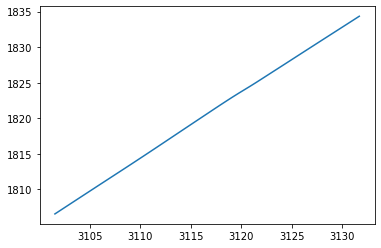

In [297]:
plt.plot(tra_20[0],tra_20[1])

In [302]:
obs = tra_20[:,0:30]

In [303]:
pre_tra_20 = np.zeros((2,50))
pre_tra_20[:,0:30] = obs

In [304]:
for i in range(30,50):
    pre_tra_20[:,i] = pre_tra_20[:,i-1] + predict[0][20].detach().numpy()[:,i-30]/10

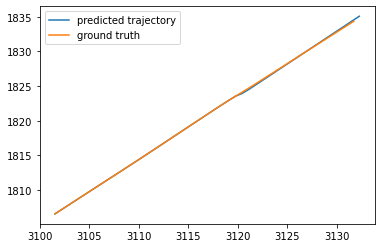

In [305]:
plt.plot(pre_tra_20[0],pre_tra_20[1],label = "predicted trajectory")
plt.plot(tra_20[0],tra_20[1], label = "ground truth")
plt.legend()

# new one

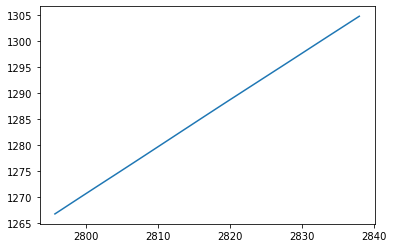

In [316]:
tra_20 = trajectory[1:208272:10][50]
plt.plot(tra_20[0],tra_20[1])

In [317]:
predict[0][50]

tensor([[5.7928, 6.1590, 6.2117, 6.2184, 6.2193, 6.2194, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194, 6.2194,
         6.2194, 6.2194],
        [2.9726, 5.2167, 5.7850, 5.8714, 5.8833, 5.8849, 5.8851, 5.8851, 5.8852,
         5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852, 5.8852,
         5.8852, 5.8852]], grad_fn=<SelectBackward0>)

In [318]:
ground_truth[0][50]

tensor([[9.4896, 8.6230, 9.2560, 8.3362, 8.9395, 8.7660, 7.8633, 7.7422, 7.6074,
         7.5355, 7.5221, 7.4763, 8.1592, 7.4236, 8.1405, 7.4935, 7.5216, 7.5422,
         8.3468, 7.7094],
        [8.4788, 7.6956, 8.2691, 7.4423, 8.0072, 7.7720, 7.0520, 6.9438, 6.8320,
         6.7683, 6.7569, 6.7171, 7.3219, 6.6649, 7.3011, 6.6688, 6.7193, 6.7435,
         7.4575, 6.8622]], dtype=torch.float64)

In [312]:
tra_20

array([[ 129.25293176,  129.24775346,  129.24751983,  129.24422743,
         129.24267349,  129.24239704,  129.24155506,  129.24450654,
         129.24469284,  129.24479937,  129.24411059,  129.24322271,
         129.23786592,  129.23492512,  129.23094236,  129.22233476,
         129.21552237,  129.20766517,  129.19667188,  129.18855056,
         129.17786357,  129.16372519,  129.15224716,  129.14144195,
         129.12687855,  129.11468202,  129.09477171,  129.0798927 ,
         129.06192099,  129.04631894,  129.02676106,  129.01010922,
         128.99197764,  128.97678406,  128.95960053,  128.93945509,
         128.92305326,  128.9046344 ,  128.88971377,  128.87410813,
         128.85526147,  128.83605946,  128.81745407,  128.79849292,
         128.78150873,  128.76499939,  128.74500015,  128.72932128,
         128.70899372,  128.690735  ],
       [3190.20073304, 3190.34421655, 3190.35762613, 3190.39672288,
        3190.45456356, 3190.51893388, 3190.56498506, 3190.56561829,
        3

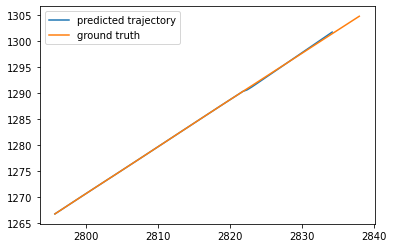

In [319]:
obs = tra_20[:,0:30]
pre_tra_20 = np.zeros((2,50))
pre_tra_20[:,0:30] = obs
for i in range(30,50):
    pre_tra_20[:,i] = pre_tra_20[:,i-1] + predict[0][50].detach().numpy()[:,i-30]*0.1
plt.plot(pre_tra_20[0],pre_tra_20[1],label = "predicted trajectory")
plt.plot(tra_20[0],tra_20[1], label = "ground truth")
plt.legend()

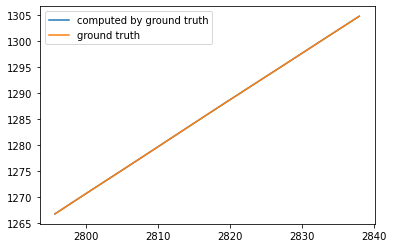

In [320]:
obs = tra_20[:,0:30]
pre_tra_20 = np.zeros((2,50))
pre_tra_20[:,0:30] = obs
for i in range(30,50):
    pre_tra_20[:,i] = pre_tra_20[:,i-1] + ground_truth[0][50].detach().numpy()[:,i-30]/10
plt.plot(pre_tra_20[0],pre_tra_20[1],label = "computed by ground truth")
plt.plot(tra_20[0],tra_20[1], label = "ground truth")
plt.legend()

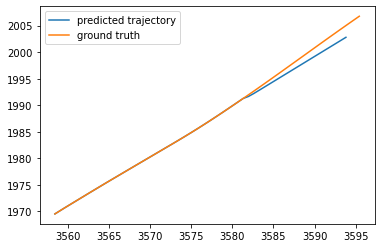

In [335]:
tra_20 = trajectory[1:208272:10][100]
#plt.plot(tra_20[0],tra_20[1])

obs = tra_20[:,0:30]
pre_tra_20 = np.zeros((2,50))
pre_tra_20[:,0:30] = obs
for i in range(30,50):
    pre_tra_20[:,i] = pre_tra_20[:,i-1] + predict[0][100].detach().numpy()[:,i-30]*0.1
plt.plot(pre_tra_20[0],pre_tra_20[1],label = "predicted trajectory")
plt.plot(tra_20[0],tra_20[1], label = "ground truth")
plt.legend()

In [328]:
predict[0][90]

tensor([[ 1.7623,  1.6462,  1.6423,  1.6428,  1.6429,  1.6430,  1.6430,  1.6430,
          1.6430,  1.6430,  1.6430,  1.6430,  1.6435,  1.6470,  1.6728,  1.8509,
          2.7179,  4.1108,  4.6356,  4.7243],
        [-7.3789, -7.1704, -7.0649, -7.0466, -7.0441, -7.0437, -7.0437, -7.0436,
         -7.0436, -7.0436, -7.0437, -7.0437, -7.0440, -7.0465, -7.0644, -7.1879,
         -7.7895, -8.7560, -9.1201, -9.1816]], grad_fn=<SelectBackward0>)

In [329]:
ground_truth[0][90]

tensor([[ 6.5590,  7.4326,  7.0611,  7.9971,  8.2938,  7.8223,  8.8152,  9.0059,
         10.0636, 10.2690,  9.7423, 10.7545, 11.9184, 10.4385, 11.5614, 10.9153,
         14.8459, 11.3128, 12.4820, 11.5950],
        [-8.8939, -9.4828, -8.4759, -8.9999, -8.7091, -7.7685, -8.2897, -7.9780,
         -8.3906, -8.0615, -7.2325, -7.5941, -7.8936, -6.5562, -6.9740, -6.1312,
         -7.8527, -5.6212, -5.8844, -5.1471]], dtype=torch.float64)

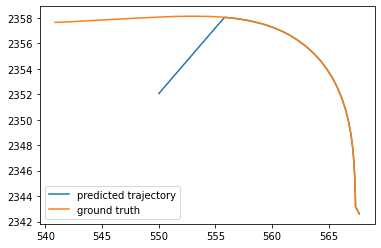

In [345]:
tra_20 = trajectory[1:208272:10][160]
#plt.plot(tra_20[0],tra_20[1])

obs = tra_20[:,0:30]
pre_tra_20 = np.zeros((2,50))
pre_tra_20[:,0:30] = obs
for i in range(30,50):
    pre_tra_20[:,i] = pre_tra_20[:,i-1] + predict[0][160].detach().numpy()[:,i-30]*0.1
plt.plot(pre_tra_20[0],pre_tra_20[1],label = "predicted trajectory")
plt.plot(tra_20[0],tra_20[1], label = "ground truth")
plt.legend()

In [337]:
predict[0][110]

tensor([[ 9.6544, 10.3085, 10.4812, 10.5043, 10.4834, 10.3135,  9.4513,  7.7165,
          6.2221,  5.6332,  5.5269,  5.5118,  5.5097,  5.5095,  5.5094,  5.5094,
          5.5094,  5.5094,  5.5094,  5.5094],
        [-2.5009, -1.3450, -1.0376, -0.9935, -1.0097, -1.1660, -1.9702, -3.6981,
         -5.4147, -6.1319, -6.2628, -6.2813, -6.2839, -6.2842, -6.2843, -6.2843,
         -6.2843, -6.2843, -6.2843, -6.2843]], grad_fn=<SelectBackward0>)

In [338]:
ground_truth[0][110]

tensor([[8.7205, 7.8741, 9.3484, 7.6643, 7.6587, 8.3214, 7.4439, 7.4224, 7.3347,
         7.2031, 6.4570, 7.7752, 7.7003, 7.5720, 7.4482, 7.4277, 6.6342, 7.7728,
         7.0705, 5.6554],
        [0.4279, 0.3997, 0.4724, 0.3938, 0.3908, 0.4182, 0.3789, 0.3685, 0.3643,
         0.3511, 0.3161, 0.3887, 0.3705, 0.3584, 0.3541, 0.3514, 0.3106, 0.3593,
         0.3189, 0.2503]], dtype=torch.float64)

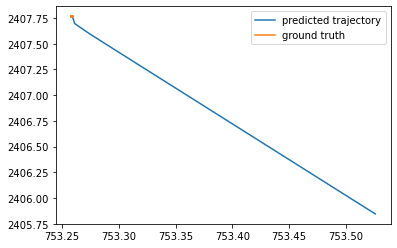

In [349]:
tra_20 = trajectory[1:208272:10][200]
#plt.plot(tra_20[0],tra_20[1])

obs = tra_20[:,0:30]
pre_tra_20 = np.zeros((2,50))
pre_tra_20[:,0:30] = obs
for i in range(30,50):
    pre_tra_20[:,i] = pre_tra_20[:,i-1] + predict[0][200].detach().numpy()[:,i-30]*0.1
plt.plot(pre_tra_20[0],pre_tra_20[1],label = "predicted trajectory")
plt.plot(tra_20[0],tra_20[1], label = "ground truth")
plt.legend()

# compute the overall error

In [113]:
pre_tra = np.zeros(trajectory[1:208272:10].shape)
pre_tra.shape

(20828, 2, 50)

In [114]:
predict[0]

tensor([[[  0.0198,   0.1225,   0.1378,  ...,   0.1402,   0.1402,   0.1402],
         [ -0.6814,  -0.9319,  -0.9705,  ...,  -0.9767,  -0.9767,  -0.9767]],

        [[ -0.3115,  -2.2244,  -2.7241,  ...,   0.1402,   0.1402,   0.1402],
         [  3.3539,   2.4825,   1.1004,  ...,  -0.9767,  -0.9767,  -0.9767]],

        [[  0.0199,   0.1225,   0.1378,  ...,   0.1402,   0.1402,   0.1402],
         [ -0.6813,  -0.9318,  -0.9705,  ...,  -0.9767,  -0.9767,  -0.9767]],

        ...,

        [[  6.7267,   6.8898,   6.0551,  ...,   5.5094,   5.5094,   5.5094],
         [ -5.1657,  -4.6336,  -5.6065,  ...,  -6.2843,  -6.2843,  -6.2843]],

        [[  1.1458,   0.0989,   0.1484,  ...,   0.1563,   0.1563,   0.1563],
         [  5.0050,   5.0062,   5.1508,  ...,   5.1735,   5.1735,   5.1735]],

        [[  1.0243,   0.1996,  -0.0204,  ...,  -0.0595,  -0.0595,  -0.0595],
         [ -8.6990,  -9.7580, -10.0390,  ..., -10.0890, -10.0890, -10.0890]]],
       grad_fn=<CopySlices>)

In [115]:
pre_tra[:,:,0:30] = trajectory[1:208272:10][:,:,0:30]

In [117]:
for i in range(len(predict)):
    predict[i] = predict[i].detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [122]:
predict = np.array(predict)

/scratch/local/52692570/ipykernel_81387/3932027576.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predict = np.array(predict)


(1000, 2, 20)